In [3]:
cd /Users/eliasimos/Desktop/last\ pull 

/Users/eliasimos/Desktop/last pull


In [4]:
ls

Final_V3.ipynb
clients_per_index.csv
double_vote_epoch.csv
double_votes_within_slots.csv
doublevotes_within_slot.csv
grouping-analysis.ipynb
merged_group_finality.csv
new_validators_by_indentifier_master.csv
new_validators_by_indentifier_master.csv.zip
same_slot_twice_attested.csv
val_ids.csv
validator_ratios.csv
validator_ratios_updates.csv


In [5]:
# load useful packages
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
sns.set()

In [6]:
m_finality = pd.read_csv('merged_group_finality.csv')
m_finality.tail()

,Unnamed: 0,lag_0,lag_1,lag_2,lag_3+,Unnamed: 0.1,0,validators_entered_cumul,validators_exited_cumul,validators_active,validator_req_ffg,validator_req_ffg_per_slot
14341,14341,43069.0,17158.0,0.0,0.0,14568,14568,76950.0,6272.0,70678.0,47119.0,1472.46875
14342,14342,39000.0,14809.0,0.0,0.0,14569,14569,76954.0,6274.0,70680.0,47120.0,1472.50000
14343,14343,43455.0,12516.0,0.0,0.0,14570,14570,76958.0,6274.0,70684.0,47123.0,1472.59375
14344,14344,44616.0,12307.0,0.0,0.0,14571,14571,76962.0,6274.0,70688.0,47125.0,1472.65625
14345,14345,42671.0,0.0,0.0,0.0,14572,14572,76972.0,6274.0,70698.0,47132.0,1472.87500


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd303c69ca0>,
      dtype=object)

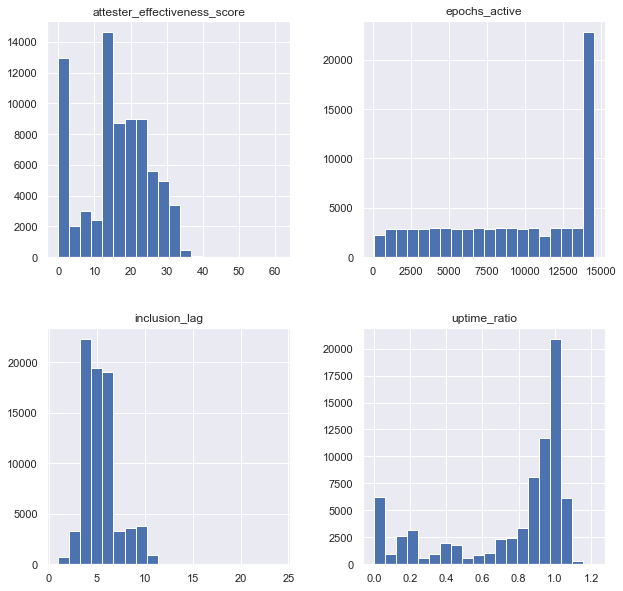

In [37]:
# load up abbreviated table of validator performance
att_eff = pd.read_csv('validator_ratios.csv')
att_eff = att_eff.rename(columns={'Unnamed: 0':'validatorindex'})
# create effectiveness score
att_eff['attester_effectiveness_score'] = att_eff['uptime_ratio']*100/att_eff['inclusion_lag']
# tidy up
att_eff_abrv = att_eff[[ 'uptime_ratio', 'inclusion_lag', 'epochs_active','attester_effectiveness_score']]
# plot histogram!
att_eff_abrv.hist(bins = 20, figsize = (10,10))

In [9]:
# load up validators by identifier
val_id = pd.read_csv('val_ids.csv')
val_id.tail()

,Unnamed: 0,identifier,validatorindex,client_identifier
69036,69036,Rocketpool/Wouimbly/Paolo,78842,unknown
69037,69037,Rocketpool/Wouimbly/Paolo,78843,unknown
69038,69038,Rocketpool/Wouimbly/Paolo,78844,unknown
69039,69039,Rocketpool/Wouimbly/Paolo,78845,unknown
69040,69040,Rocketpool/Wouimbly/Paolo,78846,unknown


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd30aae1670>,
      dtype=object)

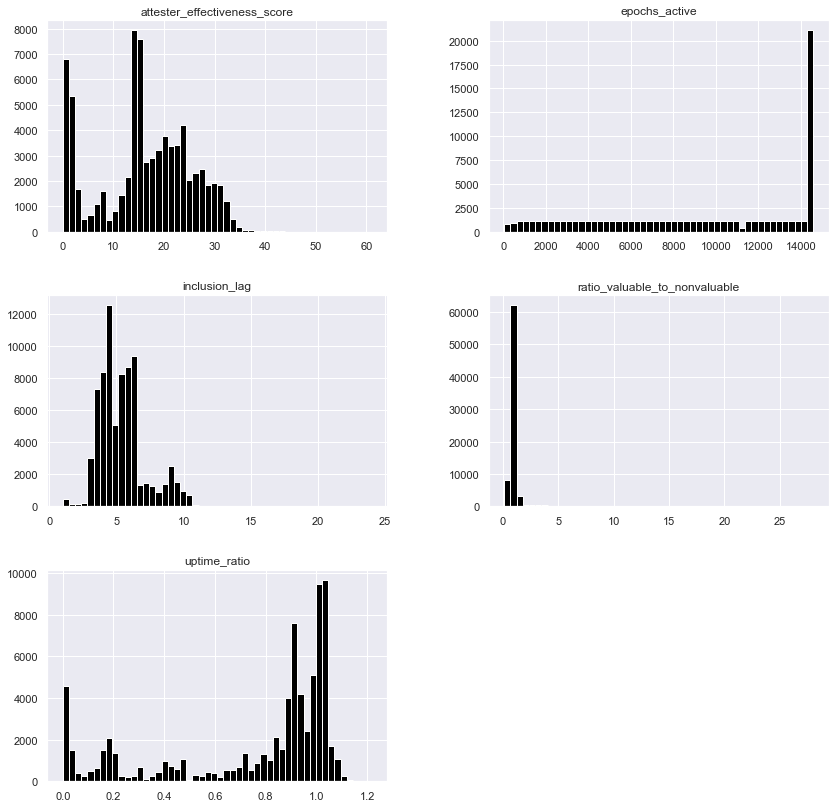

In [86]:
# merge for group performance - by identifier
val_group_perf = pd.merge(left=att_eff, right=val_id, how='left', left_on='validatorindex', right_on='validatorindex')
val_group_perf = val_group_perf[['uptime_ratio', 'inclusion_lag', 'ratio_valuable_to_nonvaluable', 'epochs_active', 'attester_effectiveness_score']]
val_group_perf.hist(color = 'black', bins = 50, figsize = (14,14))

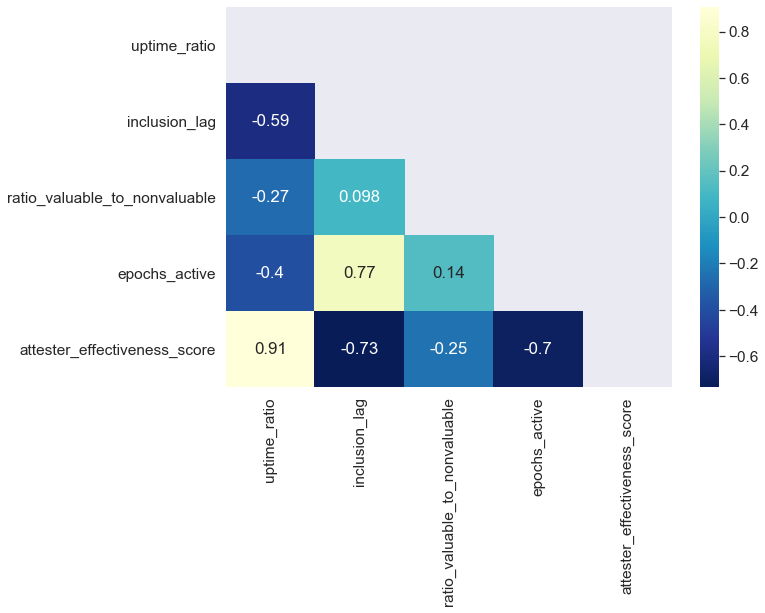

In [112]:
# heatmap of the correlation matrix of key categories by group
ax = val_group_perf.corr()    
plt.subplots(figsize=(10,7))
sns.set(font_scale=1.4)
mask = np.zeros_like(ax, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(ax, cmap="YlGnBu_r",  annot=True, mask=mask)

In [29]:
# filter for condition
pry_zm = val_group_perf.loc[val_group_perf['attester_effectiveness_score'] > 30]
pry_zm_30 = pry_zm.loc[pry_zm['client_identifier'] == 'prysm']
pry_zm_30_pvt = pd.pivot_table(pry_zm_30, index=["identifier"], values=["attester_effectiveness_score", "inclusion_lag", "uptime_ratio", 'epochs_active'], aggfunc='mean')
pry_zm_30_pvt

,attester_effectiveness_score,epochs_active,inclusion_lag,uptime_ratio
identifier,,,,
theruraljuror,33.794382,312.733333,3.203243,1.072181


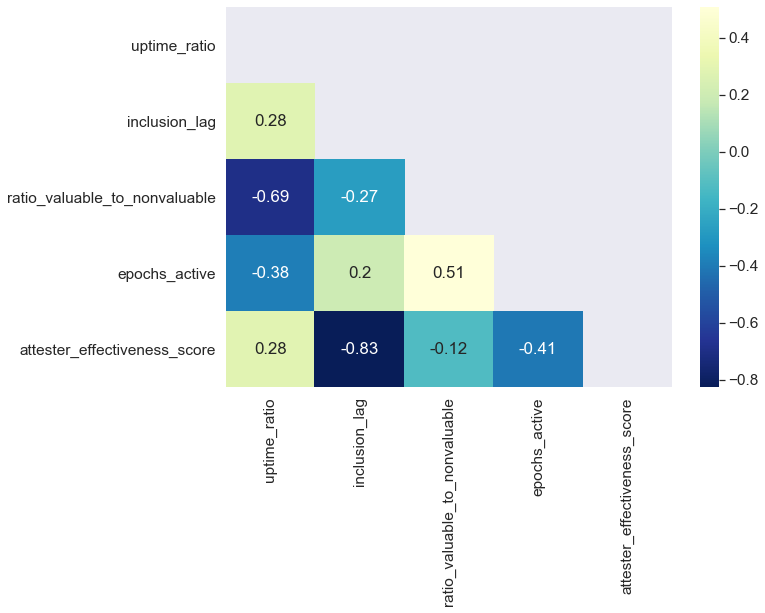

In [115]:
# only look at the very best performers
apex_perf = val_group_perf.loc[val_group_perf['attester_effectiveness_score'] > 30]
bba = apex_perf.corr()    
plt.subplots(figsize=(10,7))
sns.set(font_scale=1.4)
mask = np.zeros_like(ax, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(bba, cmap="YlGnBu_r",  annot=True, mask=mask)

In [144]:
# filter for client groupings
client_view = pd.pivot_table(val_group_perf, index=["client_identifier"], values=["ratio_valuable_to_nonvaluable", "inclusion_lag", "uptime_ratio", 'epochs_active'], aggfunc='mean')
client_view.index.name = None
#create new column with index
client_view['attester_effectiveness_score'] = client_view['uptime_ratio']*100/client_view['inclusion_lag']
client_view = client_view.sort_values(by=['attester_effectiveness_score'], ascending = False)
client_view#.drop(client_view.index[1])

,epochs_active,inclusion_lag,ratio_valuable_to_nonvaluable,uptime_ratio,attester_effectiveness_score
prysm,9414.882075,5.233650,1.025310,0.844322,16.132566
unknown,8495.628554,5.311513,0.951150,0.765017,14.403005
teku,12853.944929,5.760508,1.115971,0.804024,13.957518
lighthouse,11272.688601,5.586792,1.055909,0.767830,13.743664
lodestar,9278.530303,5.512530,1.511817,0.575342,10.436986
nimbus,13150.953908,5.903783,1.109984,0.492953,8.349777


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3089647c0>,
      dtype=object)

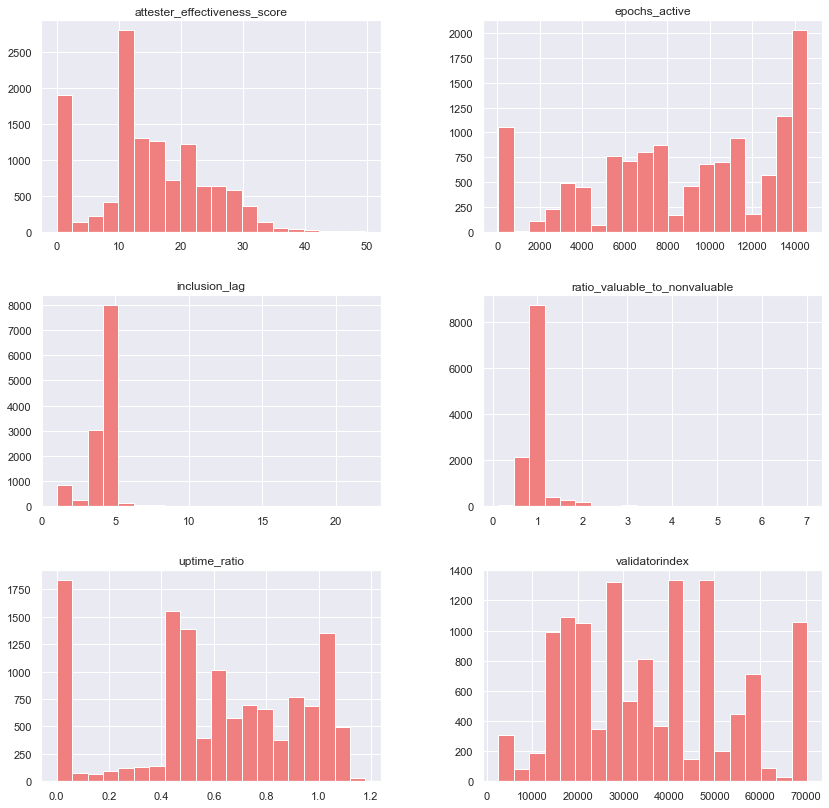

In [45]:
# prysm perf
val_group_perf_prysm = val_group_perf.loc[val_group_perf['client_identifier'] == 'prysm']
val_group_perf_prysm.hist(color = 'lightcoral', bins = 20, figsize = (14,14))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd308f54c10>,
      dtype=object)

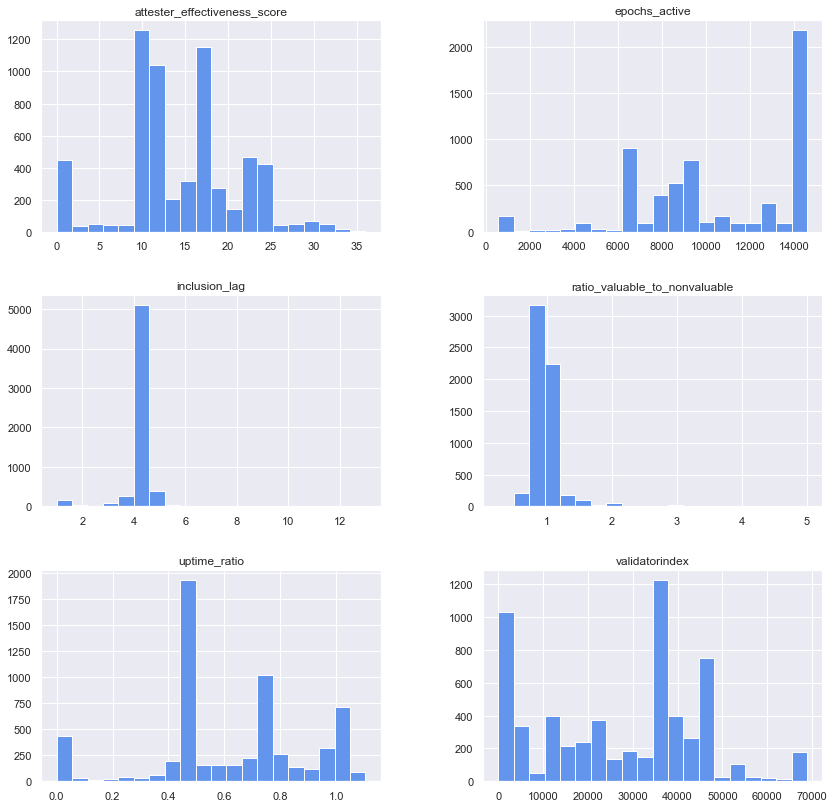

In [44]:
# lh perf
val_group_perf_lighthouse = val_group_perf.loc[val_group_perf['client_identifier'] == 'lighthouse']
val_group_perf_lighthouse.hist(color = 'cornflowerblue', bins = 20, figsize = (14,14))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd308575e50>,
      dtype=object)

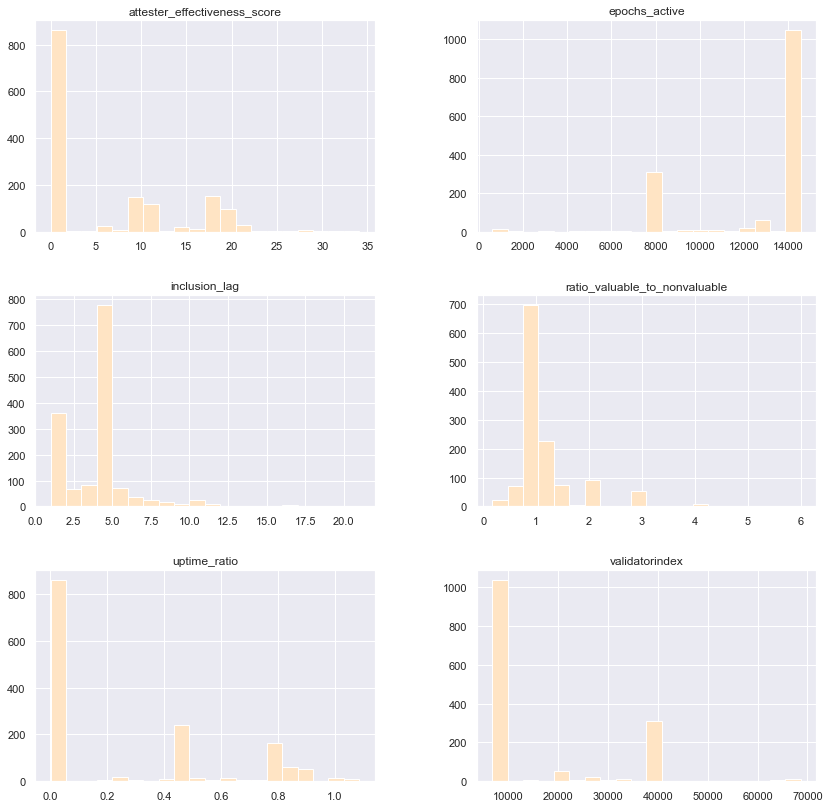

In [43]:
# nimbus perf
val_group_perf_nimbus = val_group_perf.loc[val_group_perf['client_identifier'] == 'nimbus']
val_group_perf_nimbus.hist(color = 'bisque', bins = 20, figsize = (14,14))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd308088be0>,
      dtype=object)

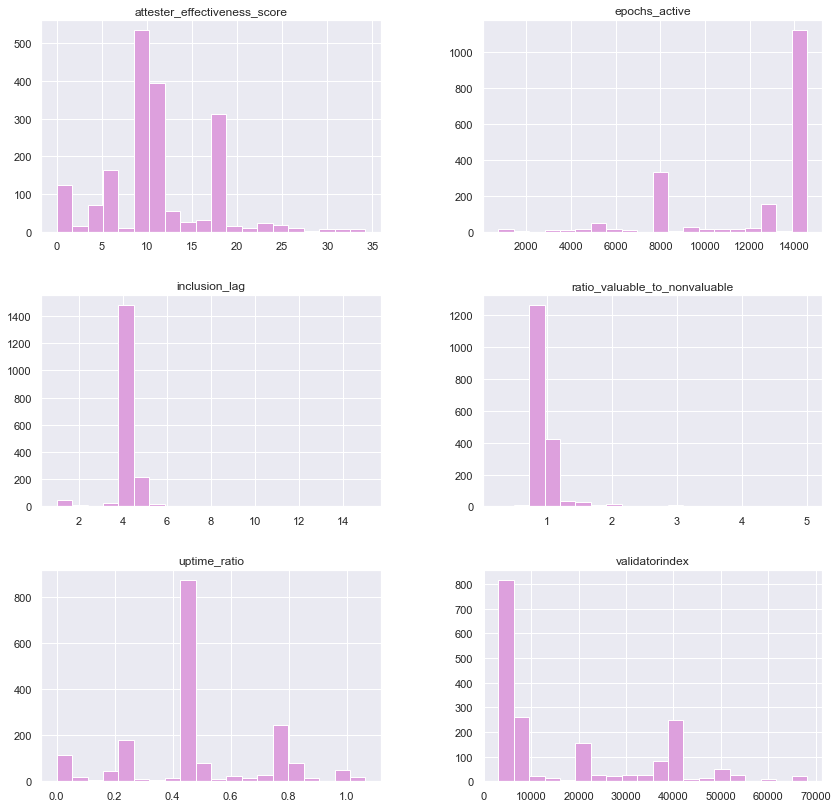

In [42]:
# teku perf
val_group_perf_teku = val_group_perf.loc[val_group_perf['client_identifier'] == 'teku']
val_group_perf_teku.hist(color = 'plum', bins = 20, figsize = (14,14))

In [51]:
group_view = pd.pivot_table(val_group_perf, index=["identifier"], values=["ratio_valuable_to_nonvaluable", "inclusion_lag", "uptime_ratio", 'epochs_active'], aggfunc='mean')
group_view.index.name = None
#create new column with index
group_view['attester_effectiveness_score'] = group_view['uptime_ratio']*100/group_view['inclusion_lag']
group_view = group_view.sort_values(by=['attester_effectiveness_score'], ascending = False)
ag = group_view.head(30)

In [52]:
ag['epochs_active'].mean()

2835.1179560849228

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd30bf8c430>,
      dtype=object)

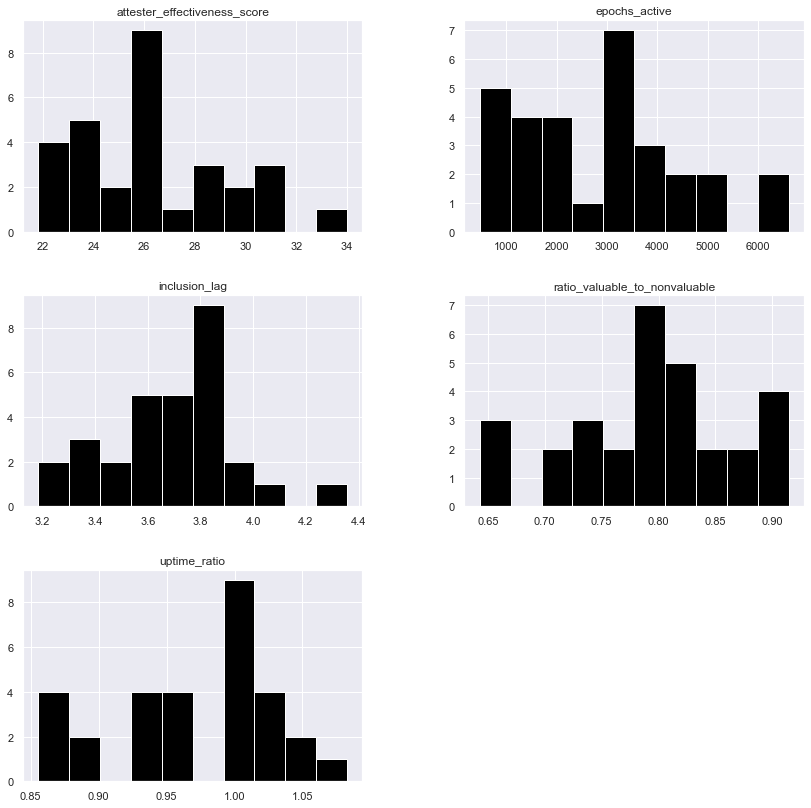

In [57]:
ag.hist(color = 'black', bins = 10, figsize = (14,14))

In [58]:
ag

,epochs_active,inclusion_lag,ratio_valuable_to_nonvaluable,uptime_ratio,attester_effectiveness_score
** | etherchest.com | **,471.000000,3.184314,0.704420,1.082803,34.004267
eth1 - 0xd9444eef25e070fbac5636884bd3ca28bd3380b1,471.750000,3.369188,0.700779,1.057774,31.395504
eth1 - 0x24cd6f1ee244562ce572dc21622c6cb150b98aa6,1345.790955,3.240013,0.894453,1.011384,31.215422
eth1 - 0x14d331f2bd6b04ec4b12b5c88c8e1e09b6c8152d,1638.542714,3.316692,0.823303,1.033408,31.157805
eth1 - 0xe58c5e457467850bfede939c6069da94b64046d9,2032.171717,3.363090,0.876832,1.020314,30.338569
eth1 - 0x7bceb533c5244a05a0cb340d68a8a8e5ed00c991,832.144737,3.539282,0.644691,1.058287,29.901180
eth1 - 0xf571f20951998c3b68ba5b1d27aefe8c462a8f56,739.108108,3.504593,0.643007,1.010339,28.829007
eth1 - 0x6f1ebc7f0043e5447ef0bab31842a9682f900e1b,692.651163,3.581567,0.650372,1.032337,28.823600
Gen - 0x00000,2393.600000,3.576893,0.815813,1.002864,28.037293
eth1 - 0xadcc449566a82f9575fec358228de1b994a04023,1999.840782,3.579111,0.759817,0.996222,27.834356
